# Testing with CATBoost

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
sns.set_theme()
from catboost import CatBoostClassifier


import sys; sys.path.append("../../")
from modules.utils import load_yaml
from modules.evaluation import pretty_classification_report, plot_confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read Data

Note: in the submission, we cannot use `test.csv`. This has no labels and it is for submission only. So we need to use validation data as the test

--> This should be OK since the data size seems large enough

In [3]:
TRAIN_CONFIG_PATH = '../../config/train_config.yaml'
DATA_PATH = '../../data/01_split/'

config = load_yaml(TRAIN_CONFIG_PATH)
LABEL_ENCODING = config['LABEL_ENCODING']

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'valid.csv'))

encoding_to_label = {v: k for k, v in LABEL_ENCODING.items()}
labels = [key for key in LABEL_ENCODING.keys()]


../../config/train_config.yaml


## Split into train and test

As said, we will use val and test as the same 

In [4]:
train_X, train_y = train_df.loc[:,train_df.columns!='leaktype'], train_df['leaktype']
valid_X, valid_y = valid_df.loc[:,train_df.columns!='leaktype'], valid_df['leaktype']

train_y = train_y.replace(LABEL_ENCODING)
valid_y = valid_y.replace(LABEL_ENCODING)

# Same testing and validation
test_X, test_y = valid_X, valid_y

## Imbalanced learning

We should attempt something for the data imbalance: better check this out

NOTE: this simple trick seems to be working!

### Weights

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(5), y=train_y)

### Smote

In [8]:
MODEL_NAME = 'CATBoost - SMOTE'

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_oversample, y_oversample = smote.fit_resample(train_X, train_y)

# Optuna optimization

https://github.com/optuna/optuna-examples/blob/main/catboost/catboost_simple.py

In [17]:
import optuna
from sklearn.metrics import f1_score, accuracy_score

# Setup metrics and data
metric = f1_score
metric_kwargs = {'average':'macro'}
data = [train_X, valid_X, train_y, valid_y]

def objective(trial,):
    train_x, valid_x, train_y, valid_y = data

    param = {
        # "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "objective":"MultiClass",
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
        "task_type": "GPU"
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    target_metric = metric(valid_y, pred_labels, **metric_kwargs)
    return target_metric


In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-06-10 00:08:55,571] A new study created in memory with name: no-name-943f62e1-3d3e-49d5-9ef6-6557ef035237
[W 2022-06-10 00:08:55,579] Trial 0 failed because of the following error: CatBoostError('catboost/private/libs/options/catboost_options.cpp:779: MVS is not supported for multiclass models on GPU')
Traceback (most recent call last):
  File "/home/botu/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_329773/492423622.py", line 32, in objective
    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)
  File "/home/botu/.local/lib/python3.10/site-packages/catboost/core.py", line 5007, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/botu/.local/lib/python3.10/site-packages/catboost/core.py", line 2262, in _fit
    train_params = se

CatBoostError: catboost/private/libs/options/catboost_options.cpp:779: MVS is not supported for multiclass models on GPU

# Train Models

<!-- Tricks: we can use custom parameters to maximize the F1 score -->

Learning rate set to 0.059223
0:	learn: 0.3983525	test: 0.5384148	best: 0.5384148 (0)	total: 21ms	remaining: 3m 30s
200:	learn: 0.7608419	test: 0.7929679	best: 0.7929679 (200)	total: 2.87s	remaining: 2m 19s
400:	learn: 0.8460245	test: 0.8439659	best: 0.8439659 (400)	total: 5.6s	remaining: 2m 14s
600:	learn: 0.8902068	test: 0.8664640	best: 0.8668964 (595)	total: 8.28s	remaining: 2m 9s
800:	learn: 0.9180553	test: 0.8804744	best: 0.8813116 (794)	total: 10.9s	remaining: 2m 5s
1000:	learn: 0.9365019	test: 0.8910432	best: 0.8918090 (992)	total: 13.5s	remaining: 2m 1s
1200:	learn: 0.9498989	test: 0.8956536	best: 0.8961039 (1147)	total: 16.1s	remaining: 1m 57s
1400:	learn: 0.9586535	test: 0.9026784	best: 0.9031445 (1397)	total: 18.6s	remaining: 1m 53s
1600:	learn: 0.9658695	test: 0.9072814	best: 0.9075420 (1590)	total: 21.1s	remaining: 1m 50s
1800:	learn: 0.9710246	test: 0.9108857	best: 0.9109126 (1799)	total: 23.6s	remaining: 1m 47s
2000:	learn: 0.9752090	test: 0.9142075	best: 0.9147836 (1995

,precision,recall,f1-score,support
0,0.933569,0.934229,0.933899,1414
1,0.924827,0.920276,0.922546,1016
2,0.989380,0.970661,0.979931,3647
3,0.718157,0.841270,0.774854,315
4,0.752161,0.795732,0.773333,328
accuracy,0.940774,0.940774,0.940774,0
macro avg,0.863619,0.892433,0.876912,6720
weighted avg,0.943584,0.940774,0.941872,6720


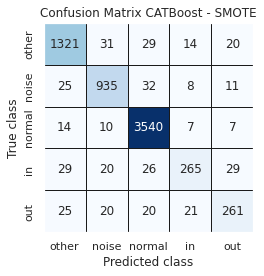

In [32]:

clf = CatBoostClassifier(
    iterations=10000,
    verbose=200,
    objective='MultiClass',
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    # devices='0:1',
    # class_weights=class_weights
)


clf.fit(
    X_oversample, y_oversample,
    # cat_features=labels,
    eval_set=(valid_X, valid_y),
)

pred_y = clf.predict(test_X)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

## Actual test for submission

In [51]:
# Setup
model = clf
LABEL_DECODING = {y:x for x,y in LABEL_ENCODING.items()}
RESULTS_PATH = '.'
DATA_DIR = '../../data/01_split'
SAMPLE_DIR = '../../data/sample_submission.csv'


test_df = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))
test_X = test_df.loc[:,test_df.columns!='id']
test_ids = test_df['id']


# Make predictions
sample_df = pd.read_csv(SAMPLE_DIR)
sorter = list(sample_df['id'])

y_pred = model.predict(test_X)
y_pred_df = pd.DataFrame(y_pred, columns=['leaktype'])
y_pred_df['leaktype'] = y_pred_df['leaktype'].replace(LABEL_DECODING)
pred_df = pd.concat([test_ids, y_pred_df],axis=1)

# sort predictions
resdf = pred_df.set_index('id')
result = resdf.loc[sorter].reset_index()
resultpath = os.path.join(RESULTS_PATH, 'predictions.csv')
result.to_csv(resultpath, index=False)